In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc
import math
import pandas as pd

In [4]:
## Setting max displayed rows to 500, in order to display the full output of any command 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])
df_train = df_train.sort_values(by='date')
df_train["rescaled_sold"] = df_train.groupby(["country", "store", "product"])["num_sold"].transform(lambda s: s/s.mean())

rescaled_df = df_train.groupby(["country", "product", "date"])["rescaled_sold"].mean().reset_index()

df_train.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'rescaled_sold'], dtype='object')

In [7]:
df_test = pd.read_csv("test.csv")
df_test["date"] = pd.to_datetime(df_test["date"])
df_test = df_test.sort_values(by='date')

In [9]:
def plot_scatter_grid(df, cols, pred, ncols=3, figsize=(16, 10), intensity = .1):
    n_plots = len(cols)
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        if len(col) == 3:
            c,s,p = col
            grouped = df.loc[(df["country"] == c) & (df["store"] == s) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {s}, {p}")
            ax.tick_params(axis="x", labelrotation=45)
        elif len(col) == 2:
            c,p = col
            grouped = df.loc[(df["country"] == c) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {p}")
            ax.tick_params(axis="x", labelrotation=45)

    # remove unused axes
    for ax in axes[len(cols):]:
        ax.remove()
    plt.tight_layout()
    plt.show()



# Take-away: we should be able to drop the rows with missing data safely.

### For each product and country, we average over all stores

Hypothesis to test: Kaggle Tiers and Kaggle are CORRELATED, have the SAME CHANGE POINTS, and they are QUADRATIC or SINUSOIDAL between two change points. Maybe the coefficients follow an AUTOREGRESSIVE MODEL. 

# Train a model using LGBM

In [39]:
import lightgbm as lgb

# -------------------------
# 1. PREPARE TRAIN DATA
# -------------------------

df = rescaled_df.copy()
df = df.sort_values(["country", "product", "date"])

# IMPORTANT: fix categorical types
df["country"] = df["country"].astype("category")
df["product"] = df["product"].astype("category")

# Freeze global time origin ONCE
global_min_date = df["date"].min()

def create_features(df):
    df = df.sort_values(["country","product","date"]).copy()
    
    # Lags
    #df["lag_1d"]  = df.set_index("date").groupby(["country", "product"])["rescaled_sold"].shift(freq="1D").reset_index(level=[0,1], drop=True)

    df = df.sort_values(["country", "product", "date"])

    #df["lag_7d"] = df.groupby(["country", "product"]).transform(lambda g: (g.set_index(df.loc[g.index, "date"])["rescaled_sold"].shift(freq="7D")))


    
    df["lag_1"]  = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(1)
    df["lag_7"]  = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(7)
    df["lag_14"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(14)
    df["lag_28"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(28)
    df["lag_180"]= df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(180)
    df["lag_365"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(365)
    
    df["rolling_7"] = (
        df.groupby(["country","product"], observed=True)["rescaled_sold"]
          .shift(1)
          .rolling(7)
          .mean()
    )
    
    # Time index (FIXED origin)
    df["t"] = (df["date"] - global_min_date).dt.days
    
    # Calendar features
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    
    # Fourier terms
    df["sin1"] = np.sin(2*np.pi*df["t"]/365)
    df["cos1"] = np.cos(2*np.pi*df["t"]/365)
    df["sin2"] = np.sin(4*np.pi*df["t"]/365)
    df["cos2"] = np.cos(4*np.pi*df["t"]/365)
    
    return df.sort_values(by = "date")

def train_test_split(data, perc):
    #data = data.values
    n = int(len(data) * (1-perc))
    
    return pd.DataFrame(data[:n]), pd.DataFrame(data[n:])

In [41]:
df = create_features(df)
df = df.dropna()
features = [c for c in df.columns if c not in ["rescaled_sold", "date"]]

df = df.copy()

for col in df.select_dtypes(include="category").columns:
    df[col] = df[col].cat.codes

#df = df.drop(columns=df.select_dtypes(include="datetime").columns)

perc = .1
train, test = train_test_split(df, perc)
X = train[features]
y = train["rescaled_sold"]


In [43]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold #For regression
from sklearn.model_selection import RandomizedSearchCV

model = LGBMRegressor()
cv = RepeatedKFold(n_splits = 5, n_repeats = 2, random_state = 0)
score = cross_val_score(model, X, y, scoring = "accuracy", cv = cv, n_jobs = -1)



In [44]:
model = LGBMRegressor(n_estimators = 3000)
model.fit(np.array(X),y)
print(y.iloc[0])
val = np.array(test[features].iloc[[0]])
pred = model.predict(val)
print(pred[0])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 57249, number of used features: 17
[LightGBM] [Info] Start training from score 1.020214
1.6301107383882698
1.0888620285515955


In [47]:
def alg_predict(train_X, train_y, val, model):
    #train = np.array(train)

    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]
    
# Walk forward validation

#from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

def careful_validate(data, perc, method):
    train, test = train_test_split(data, perc)
    X_all = train[features].values
    y_all = train["rescaled_sold"].values
    X_test = test[features].values
    y_test = test["rescaled_sold"].values
    predictions = []

    for i in range(len(X_test)):
        if method == "XGB":
            model = XGBRegressor(
                objective="reg:squarederror",
                n_estimators=3000
            )
        elif method == "LGB":
            model = LGBMRegressor(n_estimators = 3000)
        model.fit(X_all[:len(train)+i], y_all[:len(train)+i])
        pred = model.predict(X_test[i].reshape(1,-1))[0]
        predictions.append(pred)

    error = root_mean_squared_error(y_test, predictions)

    return error

def fast_validate(data, perc, model):
    train, test = train_test_split(data, perc)
    X_all = train[features].values
    y_all = train["rescaled_sold"].values
    X_test = test[features].values
    y_test = test["rescaled_sold"].values
    predictions = []

    for i in range(len(X_test)):
        #model.fit(X_all[:len(train)+i], y_all[:len(train)+i])
        #pred = model.predict(X_test[i].reshape(1,-1))[0]
        pred = alg_predict(X_all[:len(train)+i], y_all[:len(train)+i], X_test[i].reshape(1,-1), model) #i or i+1?
        predictions.append(pred)

    error = root_mean_squared_error(y_test, predictions)

    return error, y_test, predictions

def plot_predict_comparison(df, cols, preds, ncols=3, figsize=(16, 10), intensity = .1):
    n_plots = len(cols)
    pred1 = preds[0]
    pred2 = preds[1]
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        if len(col) == 3:
            c,s,p = col
            grouped = df.loc[(df["country"] == c) & (df["store"] == s) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {s}, {p}")
            ax.tick_params(axis="x", labelrotation=45)
        elif len(col) == 2:
            c,p = col
            grouped = df.loc[(df["country"] == c) & (df["product"] == p)]
            t = grouped["date"]
            s_pred1 = grouped[pred1]
            s_pred2 = grouped[pred2]
            ax.scatter(t, s_pred1, s=intensity, label = "True")
            ax.scatter(t, s_pred2, s=intensity, label = "Predicted")
            ax.set_title(f"{c}, {p}")
            ax.legend()
            ax.tick_params(axis="x", labelrotation=45)

    # remove unused axes
    for ax in axes[len(cols):]:
        ax.remove()
    plt.tight_layout()
    plt.show()




In [49]:
perc = .01
valid = fast_validate(df, perc, model)
rmse = valid[0]
y = valid[1]
pred = valid[2]
print(rmse)

0.05897795574772895


In [51]:
train, test = train_test_split(df, perc)
test["pred"] = pred

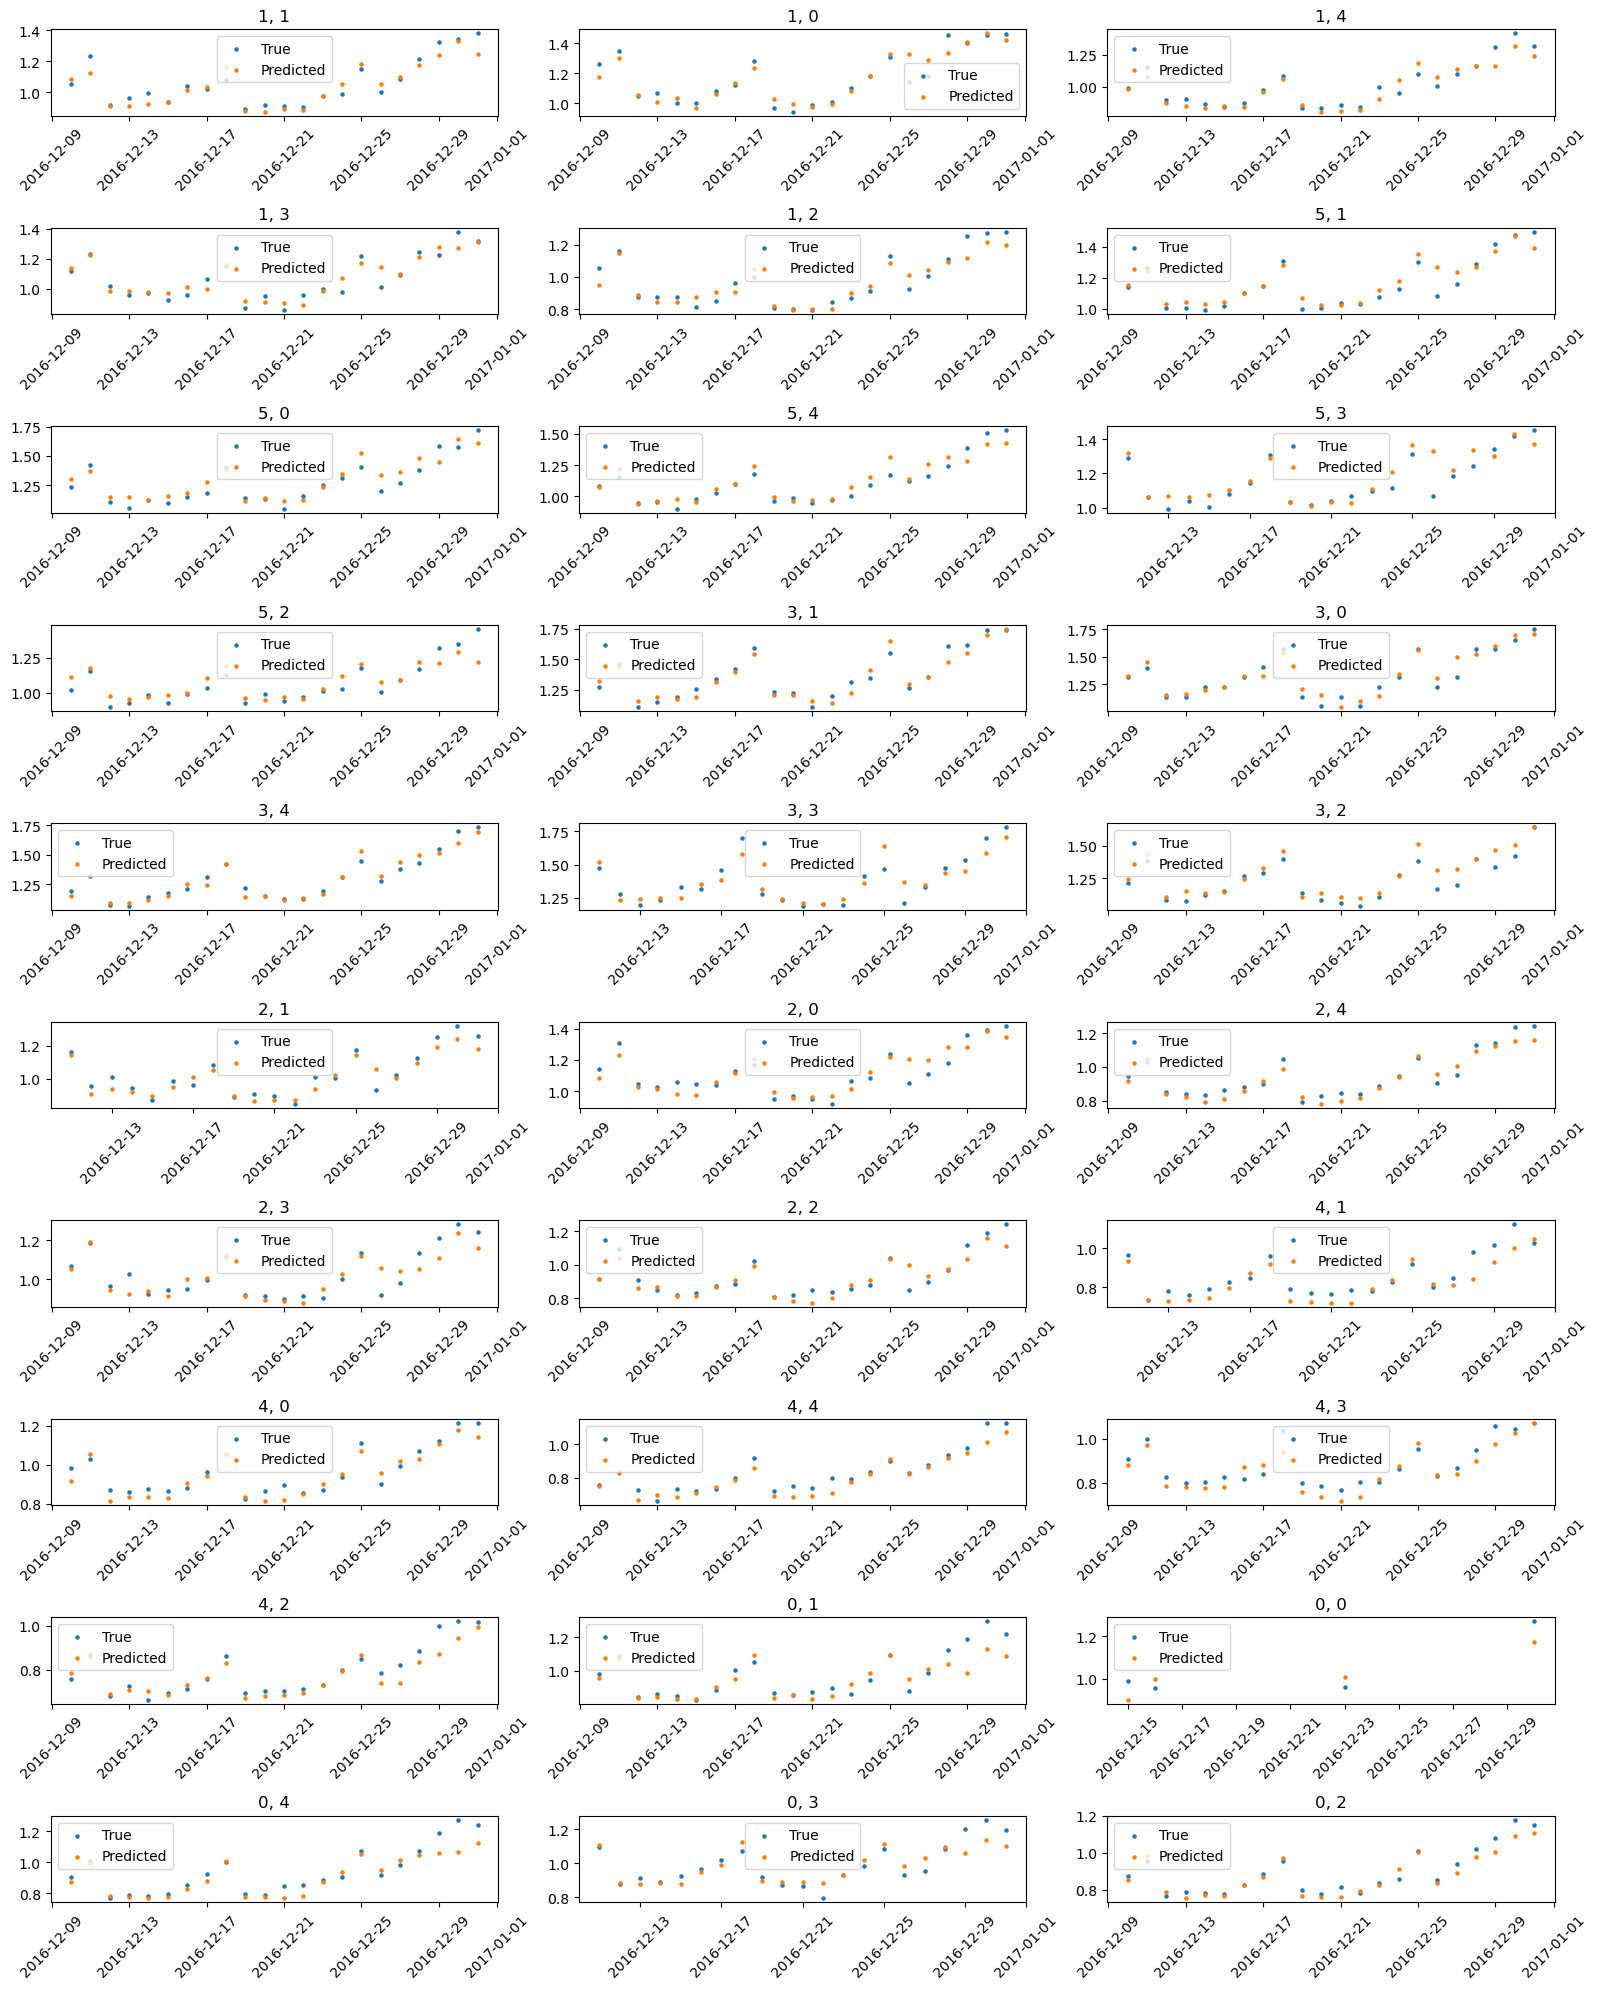

In [53]:
cols = [(c,p) for c in test["country"].unique() for p in test["product"].unique()]
preds = ["rescaled_sold", "pred"]

plot_predict_comparison(test, cols, preds, ncols=3, figsize=(16, 20), intensity = 5)

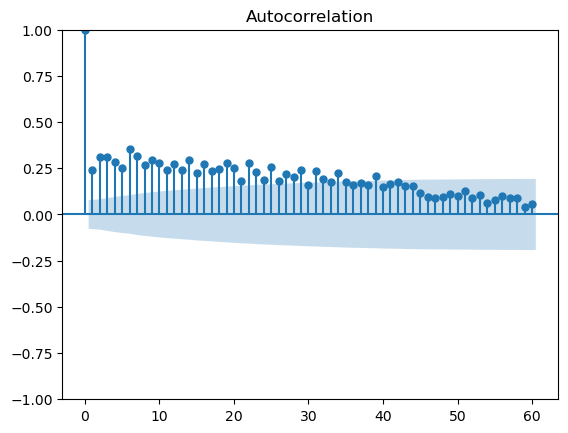

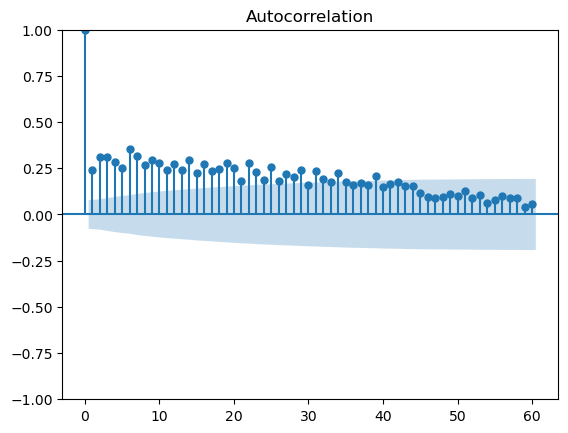

In [382]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y - pred, lags=60)

# Train a model from scratch using XGBoost

In [235]:
from xgboost import XGBRegressor


model = XGBRegressor(objective = "reg:squarederror", 
                     n_estimators = 3000)
model.fit(np.array(X),y)



In [191]:
#import xgboost
#print(xgboost.__version__)

In [236]:
y.iloc[0]

0.7965114464965555

In [237]:
val = np.array(test[features].iloc[[0]])

pred = model.predict(val)
print(pred[0])

0.90853375


In [274]:
def xgb_predict(train_X, train_y, val):
    #train = np.array(train)
    model = XGBRegressor(objective = "reg:squarederror", n_estimators = 3000)
    model.fit(train_X, train_y)

    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]

# Walk forward validation

#from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

def validate(data, perc):

    train, test = train_test_split(data, perc)

    X_all = train[features].values
    y_all = train["rescaled_sold"].values

    X_test = test[features].values
    y_test = test["rescaled_sold"].values

    predictions = []

    for i in range(len(X_test)):

        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=3000
        )

        model.fit(X_all[:len(train)+i], y_all[:len(train)+i])

        pred = model.predict(X_test[i].reshape(1,-1))[0]
        predictions.append(pred)

    error = root_mean_squared_error(y_test, predictions)

    return error


In [260]:
xgb_predict(train[features], train["rescaled_sold"], test[features].iloc[[0]])

0.90853375

In [276]:
perc = .01
valid = validate(df, perc)
rmse = valid[0]
y = valid[1]
pred = valid[2]
print(rmse)

KeyboardInterrupt: 

In [221]:
train[features]

,country,product,lag_1,lag_7,lag_14,rolling_7,t,dow,month,year,sin1,cos1,sin2,cos2
43483,3,2,0.767493,0.825530,1.103187,0.806120,14,4,1,2010,0.238673,0.971100,0.463550,0.886071
51154,4,0,0.985117,1.087625,1.441249,1.045149,14,4,1,2010,0.238673,0.971100,0.463550,0.886071
53711,4,1,0.863995,0.925153,1.246898,0.917384,14,4,1,2010,0.238673,0.971100,0.463550,0.886071
46040,3,3,0.665727,0.752316,1.072142,0.704788,14,4,1,2010,0.238673,0.971100,0.463550,0.886071
40926,3,1,0.726309,0.792038,1.093828,0.770923,14,4,1,2010,0.238673,0.971100,0.463550,0.886071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48329,3,3,0.988951,1.015026,1.068744,1.010843,2303,4,4,2016,0.930724,-0.365723,-0.680773,-0.732494
40658,3,0,0.961893,1.046041,1.053294,0.986972,2303,4,4,2016,0.930724,-0.365723,-0.680773,-0.732494
17645,1,1,0.849656,0.933550,0.864796,0.909593,2303,4,4,2016,0.930724,-0.365723,-0.680773,-0.732494
68785,5,1,0.929264,1.003576,0.999895,1.011645,2303,4,4,2016,0.930724,-0.365723,-0.680773,-0.732494


Hypothesis: Kerneler and Kerneler dark mode are in opposition of phase, have the same change points, and are sinusoidal over each period.

# Train a model

Gradient boosting (LightGBM/XGBoost/CatBoost): Does not know about time, autocorrelation, sees only tabular features

So we must explicitly create trend, seasonality, lags, rolling features. Time structure must be engineered.

In [9]:
# =========================
# RECURSIVE LIGHTGBM FORECAST
# =========================

import pandas as pd
import numpy as np
import lightgbm as lgb

# -------------------------
# 1. PREPARE TRAIN DATA
# -------------------------

df = rescaled_df.copy()
df = df.sort_values(["country", "product", "date"])

# IMPORTANT: fix categorical types
df["country"] = df["country"].astype("category")
df["product"] = df["product"].astype("category")

# Freeze global time origin ONCE
global_min_date = df["date"].min()

def create_features(df):
    df = df.sort_values(["country","product","date"]).copy()
    
    # Lags
    df["lag_1"]  = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(1)
    df["lag_7"]  = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(7)
    df["lag_14"] = df.groupby(["country","product"], observed=True)["rescaled_sold"].shift(14)
    
    df["rolling_7"] = (
        df.groupby(["country","product"], observed=True)["rescaled_sold"]
          .shift(1)
          .rolling(7)
          .mean()
    )
    
    # Time index (FIXED origin)
    df["t"] = (df["date"] - global_min_date).dt.days
    
    # Calendar features
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    
    # Fourier terms
    df["sin1"] = np.sin(2*np.pi*df["t"]/365)
    df["cos1"] = np.cos(2*np.pi*df["t"]/365)
    df["sin2"] = np.sin(4*np.pi*df["t"]/365)
    df["cos2"] = np.cos(4*np.pi*df["t"]/365)
    
    return df

df = create_features(df)
df = df.dropna()

features = [c for c in df.columns if c not in ["rescaled_sold", "date"]]
# -------------------------
# 2. FUNCTION TO TRAIN MODEL
# -------------------------

def train_lgb(df, n_est, lr, n_leaves, subsamp, colsamp_bt, rdm_st):
    
    model = lgb.LGBMRegressor(
        n_estimators=n_est,
        learning_rate=lr,
        num_leaves=n_leaves,
        subsample=subsamp,
        colsample_bytree=colsamp_bt,
        random_state=rdm_st
    )
    
    model.fit(
        df[features],
        df["rescaled_sold"],
        categorical_feature=["country","product"]
    )

    return model


# -------------------------
# 3. RECURSIVE FORECAST
# -------------------------

def recursive_forecast_fast(model, df_train, rescaled_df, test):

    # Ensure categorical consistency
    test["country"] = pd.Categorical(test["country"], categories=df_train["country"].cat.categories)
    test["product"] = pd.Categorical(test["product"], categories=df_train["product"].cat.categories)

    # Build history dictionary
    history_dict = {}

    for (c, p), g in rescaled_df.groupby(["country","product"], observed = False):
        history_dict[(c,p)] = list(g.sort_values("date")["rescaled_sold"].values)

    predictions = []

    for current_date in sorted(test["date"].unique()):

        current_rows = test[test["date"] == current_date].copy()
        feats = []

        for idx, row in current_rows.iterrows():

            key = (row["country"], row["product"])
            series = history_dict[key]

            lag_1  = series[-1]
            lag_7  = series[-7]
            lag_14 = series[-14]
            rolling_7 = np.mean(series[-7:])

            t = (current_date - global_min_date).days
            dow = current_date.dayofweek
            month = current_date.month
            year = current_date.year

            sin1 = np.sin(2*np.pi*t/365)
            cos1 = np.cos(2*np.pi*t/365)
            sin2 = np.sin(4*np.pi*t/365)
            cos2 = np.cos(4*np.pi*t/365)

            feats.append([
                row["country"], row["product"],
                lag_1, lag_7, lag_14, rolling_7,
                t, dow, month, year,
                sin1, cos1, sin2, cos2
            ])

        X = pd.DataFrame(feats, columns=features)

        X["country"] = pd.Categorical(
            X["country"],
            categories=df_train["country"].cat.categories
        )
        X["product"] = pd.Categorical(
            X["product"],
            categories=df_train["product"].cat.categories
        )

        preds = model.predict(X)

        # Update history
        for i, row in enumerate(current_rows.itertuples()):
            key = (row.country, row.product)
            history_dict[key].append(preds[i])

        current_rows["rescaled_sold"] = preds
        predictions.append(current_rows[["id","rescaled_sold"]])

    return predictions






In [31]:
n_est = 2000
lr = 0.02
n_leaves = 64
subsamp = 0.8
colsamp_bt = 0.8
rdm_st = 42

cutoff = "2016-01-01"
train = df[df["date"] < cutoff].copy()
valid = df[df["date"] >= cutoff].copy()
valid = valid.copy()
valid["id"] = np.arange(len(valid))
valid = valid[["id","country","product","date"]]

model = train_lgb(train, n_est, lr, n_leaves, subsamp, colsamp_bt, rdm_st)

predictions = recursive_forecast_fast(model, train, train, valid) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 63474, number of used features: 14
[LightGBM] [Info] Start training from score 1.005274


In [11]:
# -------------------------
# 4. LOAD TEST DATA
# -------------------------

test = pd.read_csv("test.csv")
test["date"] = pd.to_datetime(test["date"])

# Ensure same categorical levels
test["country"] = pd.Categorical(test["country"], categories=df["country"].cat.categories)
test["product"] = pd.Categorical(test["product"], categories=df["product"].cat.categories)

test = test[["id","country","product","date"]]

In [ ]:
# -------------------------
# 4. LOAD TEST DATA
# -------------------------

test = pd.read_csv("test.csv")
test["date"] = pd.to_datetime(test["date"])

# Ensure same categorical levels
test["country"] = pd.Categorical(test["country"], categories=df["country"].cat.categories)
test["product"] = pd.Categorical(test["product"], categories=df["product"].cat.categories)

test = test[["id","country","product","date"]]


# -------------------------
# 5. CREATE SUBMISSION
# -------------------------

submission = pd.concat(predictions).sort_values("id")
submission.to_csv("submission2.csv", index=False)

print("Done. Submission saved as submission2.csv")


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

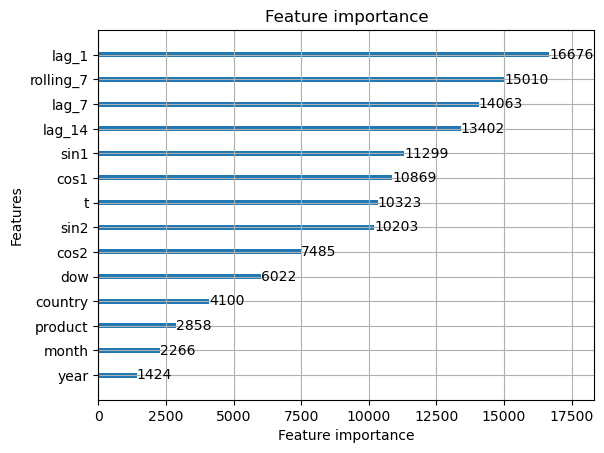

In [25]:
lgb.plot_importance(model, max_num_features=20)


In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

df = rescaled_df


# ========= 1. PREPARE DATA =========

df = df.copy()
df = df.sort_values(["country", "product", "date"])

group_cols = ["country", "product"]

# --- Safe lag features (no leakage) ---
df["lag_1"] = df.groupby(group_cols)["rescaled_sold"].shift(1)
df["lag_7"] = df.groupby(group_cols)["rescaled_sold"].shift(7)
df["lag_28"] = df.groupby(group_cols)["rescaled_sold"].shift(28)

# --- Rolling mean (shift FIRST to avoid leakage) ---
df["roll_7"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(7)
      .mean()
)

# --- Time features ---
df["t"] = (df["date"] - df["date"].min()).dt.days
df["dow"] = df["date"].dt.dayofweek

# Drop rows with missing lag values
df = df.dropna()

# ========= 2. TRAIN / VALID SPLIT =========

cutoff_date = df["date"].max() - pd.Timedelta(days=60)

train = df[df["date"] < cutoff_date].copy()
valid = df[df["date"] >= cutoff_date].copy()

# ========= 3. ENCODE CATEGORICALS =========

for col in ["country", "product"]:
    train[col] = train[col].astype("category")
    valid[col] = valid[col].astype("category")

features = [
    "country", "product",
    "t", "dow",
    "lag_1", "lag_7", "lag_28",
    "roll_7"
]

train_data = lgb.Dataset(
    train[features],
    label=train["rescaled_sold"],
    categorical_feature=["country", "product"]
)

valid_data = lgb.Dataset(
    valid[features],
    label=valid["rescaled_sold"],
    categorical_feature=["country", "product"]
)

# ========= 4. TRAIN MODEL =========

params = {
    "objective": "poisson",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "subsample": 0.8,
    "verbosity": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(50)
    ]
)

# ========= 5. VALIDATION PREDICTIONS =========

valid["predicted"] = model.predict(
    valid[features],
    num_iteration=model.best_iteration
)

rmse = np.sqrt(mean_squared_error(
    valid["rescaled_sold"],
    valid["predicted"]
))

print("Validation RMSE:", rmse)


Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.0837926
[100]	valid_0's rmse: 0.0600654
[150]	valid_0's rmse: 0.0549705
[200]	valid_0's rmse: 0.0534712
[250]	valid_0's rmse: 0.0529258
[300]	valid_0's rmse: 0.0528091
[350]	valid_0's rmse: 0.0527248
[400]	valid_0's rmse: 0.0527741
[450]	valid_0's rmse: 0.052907
Early stopping, best iteration is:
[363]	valid_0's rmse: 0.0527025
Validation RMSE: 0.05270253919309267


In [11]:
from sklearn.preprocessing import LabelEncoder

df = rescaled_df
df = df.sort_values(["product", "country", "date"])
df["t"] = (df["date"] - df["date"].min()).dt.days
df["dow"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["sin1"] = np.sin(2*np.pi*df["t"]/365)
df["cos1"] = np.cos(2*np.pi*df["t"]/365)
df["sin2"] = np.sin(4*np.pi*df["t"]/365)
df["cos2"] = np.cos(4*np.pi*df["t"]/365)

group_cols = ["product", "country"]

df["lag_1"] = df.groupby(group_cols)["rescaled_sold"].shift(1)
df["lag_7"] = df.groupby(group_cols)["rescaled_sold"].shift(7)
df["lag_14"] = df.groupby(group_cols)["rescaled_sold"].shift(14)
df["lag_28"] = df.groupby(group_cols)["rescaled_sold"].shift(28)
df["lag_56"] = df.groupby(group_cols)["rescaled_sold"].shift(56)
df["lag_365"] = df.groupby(group_cols)["rescaled_sold"].shift(365)

df["roll_7"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(7)
      .mean()
)
df["roll_14"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(14)
      .mean()
)
df["roll_28"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(28)
      .mean()
)
# Drop rows with missing lags. We loose the first rows, which is fine.
df = df.dropna()

valid1 = df[df["date"] >= "2016-01-01"].copy()

# Encodes the object variables as categoricals.
for col in ["product", "country"]:
    df[col] = LabelEncoder().fit_transform(df[col])

valid = df[df["date"] >= "2016-01-01"]
train = df[df["date"] < "2016-01-01"]



print(len(train))
print(len(valid))

52961
10677


In [15]:
import lightgbm as lgb

features = [c for c in df.columns if c not in ["rescaled_sold", "date"]]

train_data = lgb.Dataset(train[features], label=train["rescaled_sold"])
valid_data = lgb.Dataset(valid[features], label=valid["rescaled_sold"])

params = {
    #"objective": "poisson",   # good for count data
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "subsample": 0.8
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=2000,
    #early_stopping_rounds=100 #Earlier version
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3596
[LightGBM] [Info] Number of data points in the train set: 52961, number of used features: 18
[LightGBM] [Info] Start training from score 1.023318
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.0474664
[100]	valid_0's rmse: 0.0421336
[150]	valid_0's rmse: 0.0416139
[200]	valid_0's rmse: 0.0414364
[250]	valid_0's rmse: 0.0413546
[300]	valid_0's rmse: 0.041324
[350]	valid_0's rmse: 0.0412661
[400]	valid_0's rmse: 0.0412351
[450]	valid_0's rmse: 0.0412393
[500]	valid_0's rmse: 0.04126
Early stopping, best iteration is:
[412]	valid_0's rmse: 0.041222


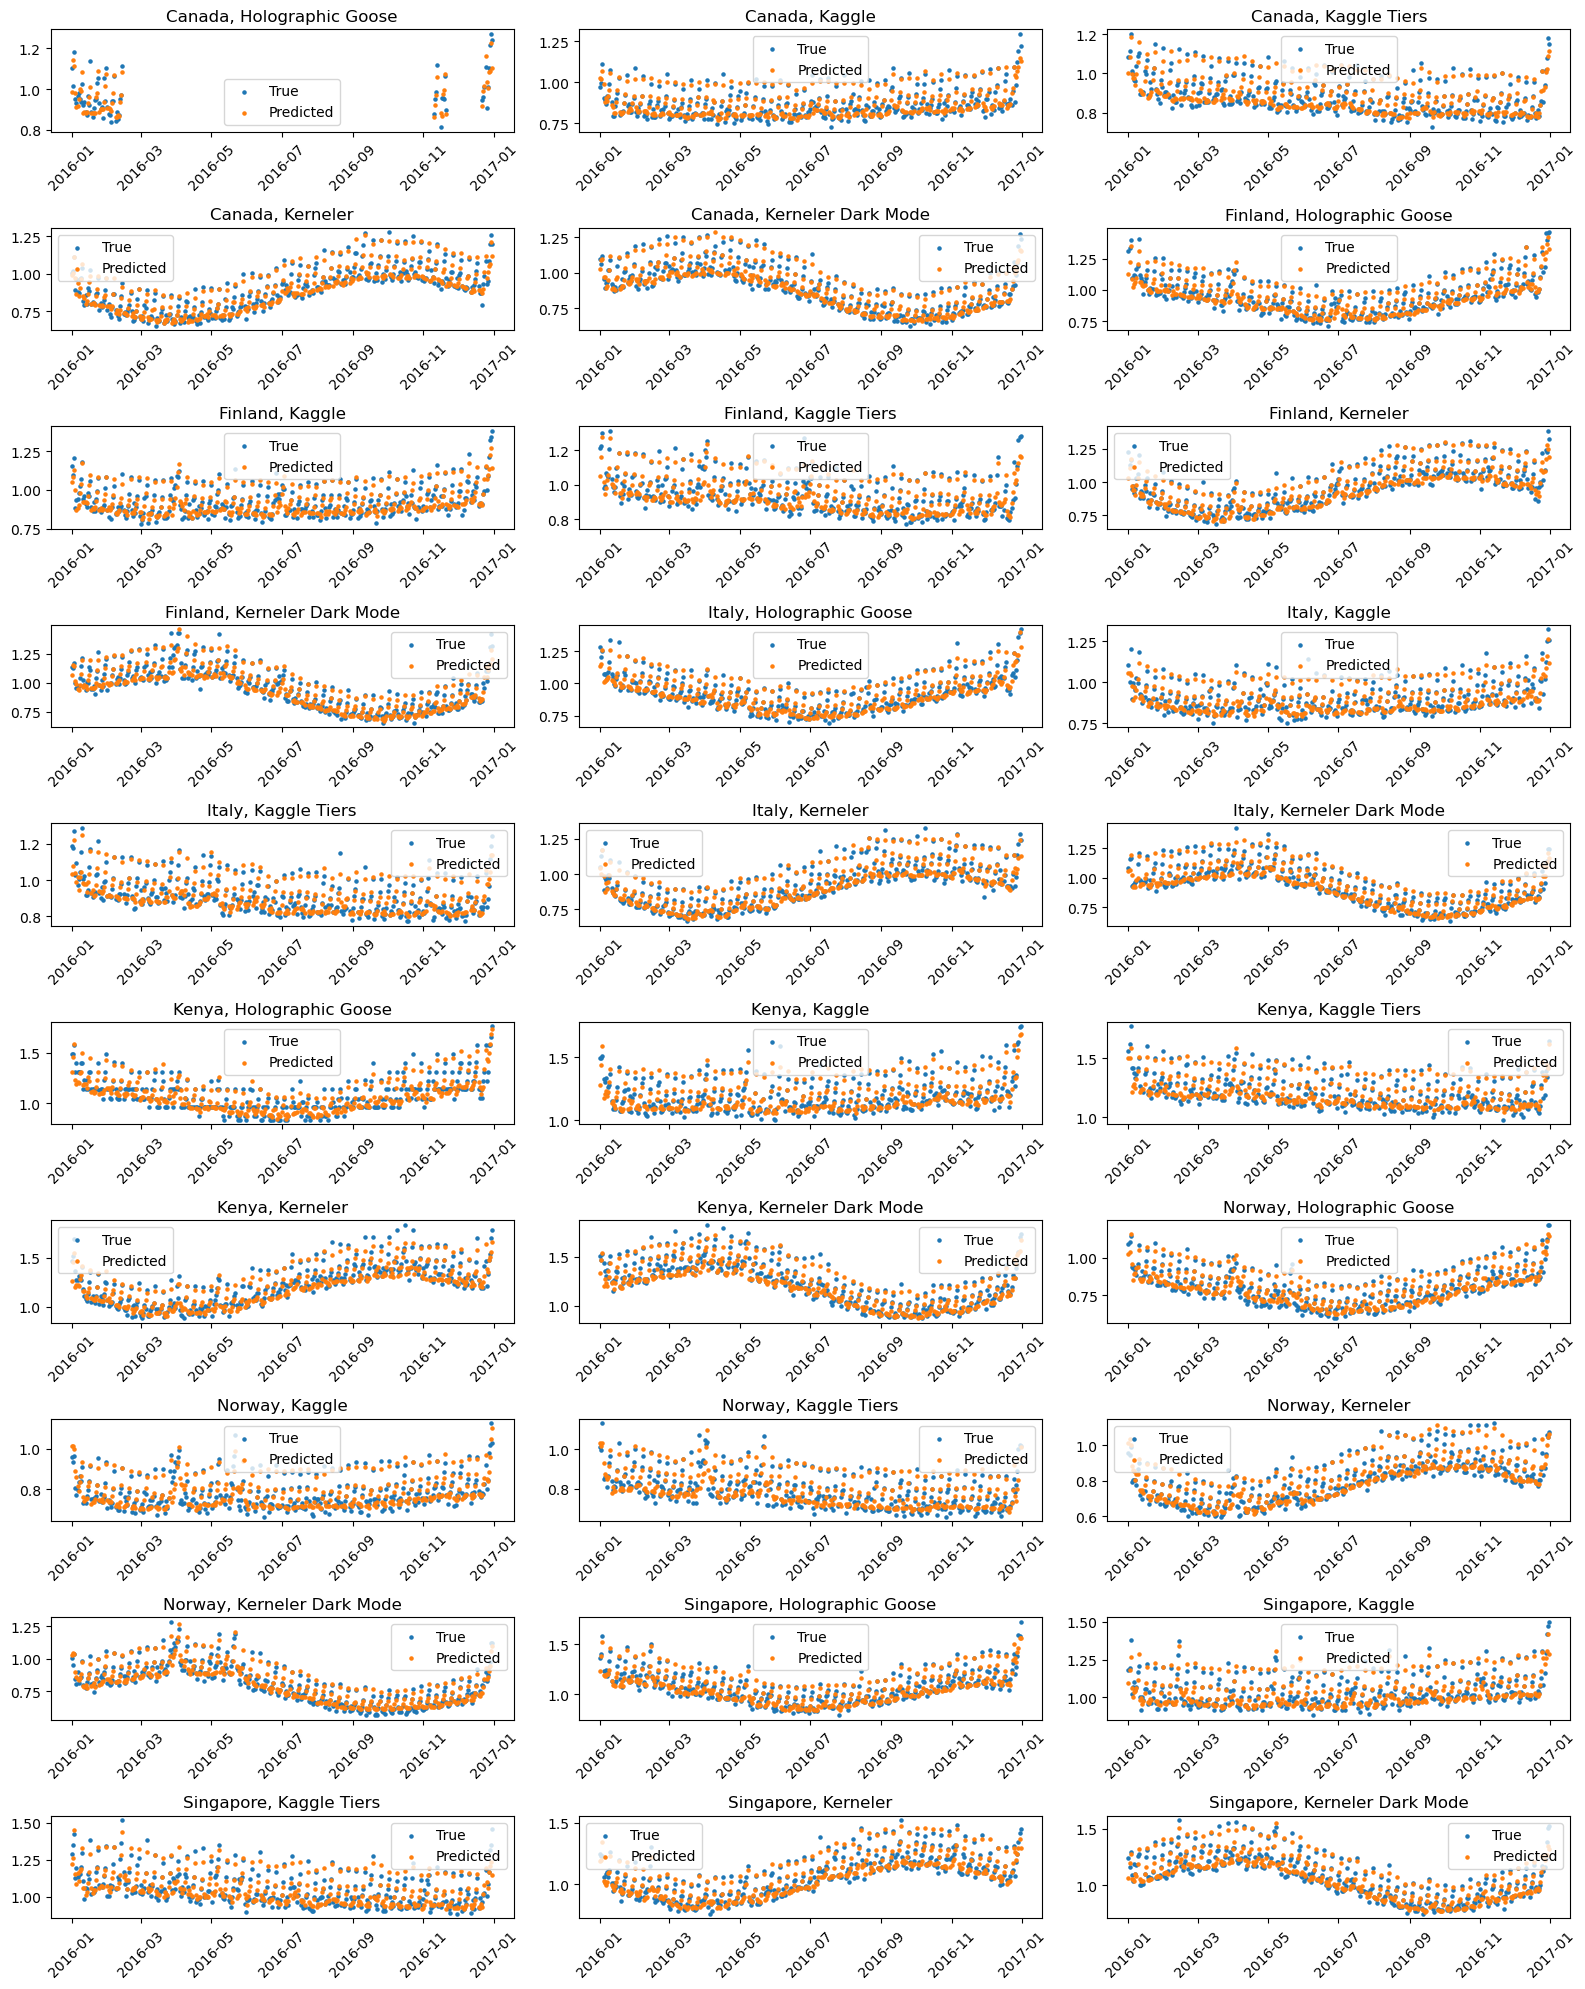

In [17]:
valid2 = valid1.copy()

for col in ["product", "country"]:
    valid2[col] = LabelEncoder().fit_transform(valid2[col])

valid1["predicted"] = model.predict(
    valid2[features],
    num_iteration=model.best_iteration
)


def plot_predict_comparison(df, cols, preds, ncols=3, figsize=(16, 10), intensity = .1):
    n_plots = len(cols)
    pred1 = preds[0]
    pred2 = preds[1]
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        if len(col) == 3:
            c,s,p = col
            grouped = df.loc[(df["country"] == c) & (df["store"] == s) & (df["product"] == p)]
            t = grouped["date"]
            s_pred = grouped[pred]
            ax.scatter(t, s_pred, s=intensity)
            ax.set_title(f"{c}, {s}, {p}")
            ax.tick_params(axis="x", labelrotation=45)
        elif len(col) == 2:
            c,p = col
            grouped = df.loc[(df["country"] == c) & (df["product"] == p)]
            t = grouped["date"]
            s_pred1 = grouped[pred1]
            s_pred2 = grouped[pred2]
            ax.scatter(t, s_pred1, s=intensity, label = "True")
            ax.scatter(t, s_pred2, s=intensity, label = "Predicted")
            ax.set_title(f"{c}, {p}")
            ax.legend()
            ax.tick_params(axis="x", labelrotation=45)

    # remove unused axes
    for ax in axes[len(cols):]:
        ax.remove()
    plt.tight_layout()
    plt.show()


cols = [(c,p) for c in valid1["country"].unique() for p in valid1["product"].unique()]
preds = ["rescaled_sold", "predicted"]

plot_predict_comparison(valid1, cols, preds, ncols=3, figsize=(16, 20), intensity = 5)

In [19]:
def add_lag_features(df):
    df = df.sort_values(["country", "product", "date"])

    df["t"] = (df["date"] - df["date"].min()).dt.days
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["sin1"] = np.sin(2*np.pi*df["t"]/365)
    df["cos1"] = np.cos(2*np.pi*df["t"]/365)
    df["sin2"] = np.sin(4*np.pi*df["t"]/365)
    df["cos2"] = np.cos(4*np.pi*df["t"]/365)

    group_cols = ["country", "product"]

    df["lag_1"] = df.groupby(group_cols)["rescaled_sold"].shift(1)
    df["lag_7"] = df.groupby(group_cols)["rescaled_sold"].shift(7)
    df["lag_14"] = df.groupby(group_cols)["rescaled_sold"].shift(14)
    df["lag_28"] = df.groupby(group_cols)["rescaled_sold"].shift(28)
    df["lag_56"] = df.groupby(group_cols)["rescaled_sold"].shift(56)
    df["lag_365"] = df.groupby(group_cols)["rescaled_sold"].shift(365)

    df["roll_7"] = (
        df.groupby(group_cols)["rescaled_sold"]
          .shift(1)
          .rolling(7)
          .mean()
    )
    df["roll_14"] = (
        df.groupby(group_cols)["rescaled_sold"]
          .shift(1)
          .rolling(14)
          .mean()
    )
    df["roll_28"] = (
        df.groupby(group_cols)["rescaled_sold"]
          .shift(1)
          .rolling(28)
          .mean()
    )

    for col in ["product", "country"]:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df


def recursive_validation(model, df, features, val_start, val_end):

    df = df.copy()

    # Ensure sorted
    df = df.sort_values(["country", "product", "date"])

    validation_dates = df.loc[
        (df["date"] >= val_start) &
        (df["date"] <= val_end),
        "date"
    ].sort_values().unique()

    predictions = []

    for current_date in validation_dates:

        # Recompute lag features using updated history
        df = add_lag_features(df)

        # Select rows to predict
        mask = df["date"] == current_date
        X_pred = df.loc[mask, features]

        # Predict
        y_pred = model.predict(X_pred, num_iteration=model.best_iteration)

        # Store predictions
        predictions.append(
            df.loc[mask, ["country", "product", "date"]]
              .assign(predicted=y_pred)
        )

        # Replace true values with predictions
        df.loc[mask, "rescaled_sold"] = y_pred

    return pd.concat(predictions)


In [21]:
import lightgbm as lgb

features = [c for c in df.columns if c not in ["rescaled_sold", "date"]]

train_data = lgb.Dataset(train[features], label=train["rescaled_sold"])
valid_data = lgb.Dataset(valid[features], label=valid["rescaled_sold"])

params = {
    #"objective": "poisson",   # good for count data
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "subsample": 0.8
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=2000,
    #early_stopping_rounds=100 #Earlier version
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)
    ]
)


val_preds = recursive_validation(
    model,
    rescaled_df,
    features,
    val_start="2016-10-01",
    val_end="2016-12-31"
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3596
[LightGBM] [Info] Number of data points in the train set: 52961, number of used features: 18
[LightGBM] [Info] Start training from score 1.023318
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.0474664
[100]	valid_0's rmse: 0.0421336
[150]	valid_0's rmse: 0.0416139
[200]	valid_0's rmse: 0.0414364
[250]	valid_0's rmse: 0.0413546
[300]	valid_0's rmse: 0.041324
[350]	valid_0's rmse: 0.0412661
[400]	valid_0's rmse: 0.0412351
[450]	valid_0's rmse: 0.0412393
[500]	valid_0's rmse: 0.04126
Early stopping, best iteration is:
[412]	valid_0's rmse: 0.041222


In [33]:
df_original = rescaled_df

true_vals = df_original.loc[
    (df_original["date"] >= "2016-10-01") &
    (df_original["date"] <= "2016-12-31"),
    ["country", "product", "date", "rescaled_sold"]
]

merged = val_preds.merge(
    true_vals,
    on=["country", "product", "date"],
    suffixes=("_pred", "_true")
)


ValueError: You are trying to merge on int64 and object columns for key 'country'. If you wish to proceed you should use pd.concat

In [ ]:
true_vals

In [13]:
from sklearn.preprocessing import LabelEncoder

df = rescaled_df
df = df.sort_values(["product", "country", "date"])
df["t"] = (df["date"] - df["date"].min()).dt.days
df["dow"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["sin1"] = np.sin(2*np.pi*df["t"]/365)
df["cos1"] = np.cos(2*np.pi*df["t"]/365)
df["sin2"] = np.sin(4*np.pi*df["t"]/365)
df["cos2"] = np.cos(4*np.pi*df["t"]/365)

group_cols = ["product", "country"]

df["lag_1"] = df.groupby(group_cols)["rescaled_sold"].shift(1)
df["lag_7"] = df.groupby(group_cols)["rescaled_sold"].shift(7)
df["lag_14"] = df.groupby(group_cols)["rescaled_sold"].shift(14)
df["lag_28"] = df.groupby(group_cols)["rescaled_sold"].shift(28)
df["lag_56"] = df.groupby(group_cols)["rescaled_sold"].shift(56)
df["lag_365"] = df.groupby(group_cols)["rescaled_sold"].shift(365)

df["roll_7"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(7)
      .mean()
)
df["roll_14"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(14)
      .mean()
)
df["roll_28"] = (
    df.groupby(group_cols)["rescaled_sold"]
      .shift(1)
      .rolling(28)
      .mean()
)
# Drop rows with missing lags. We loose the first rows, which is fine.
df = df.dropna()

valid1 = df[df["date"] >= "2016-01-01"].copy()

# Encodes the object variables as categoricals.
for col in ["product", "country"]:
    df[col] = LabelEncoder().fit_transform(df[col])

valid = df[df["date"] >= "2016-01-01"]
train = df[df["date"] < "2016-01-01"]



print(len(train))
print(len(valid))

52961
10677


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

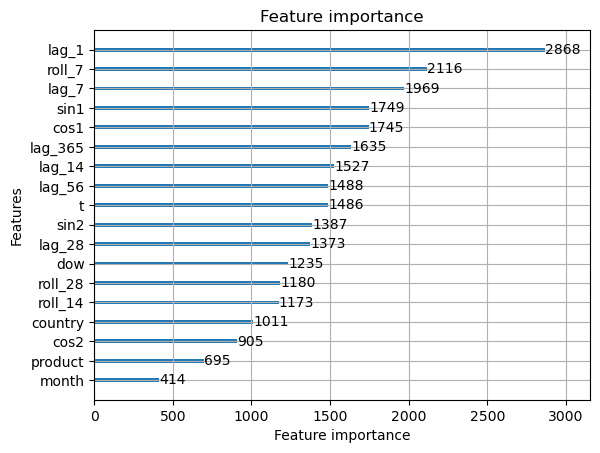

In [168]:
lgb.plot_importance(model, max_num_features=20)


## Lags appear among the most important predictors, which is good. It means that time dependence is taken into account.

In [58]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    objective="poisson",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=64
)

model.fit(
    train[features],
    train["num_sold"],
    eval_set=[(valid[features], valid["num_sold"])],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100)]
)


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: store: object